In [10]:
import scanpy as sc
sc.settings.verbosity = 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
root_dir = os.path.join(os.getcwd(), '..')
if root_dir not in sys.path:
    sys.path.append(root_dir)
# from src.Pipeline import *
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import anndata 
# import plotly.express as px
from scipy import stats
from scipy import spatial
# from src.Demo import *
# from src.Pipeline import *
# from src.svi import *
# from src.draw import *
# from src.preprocess import *
# from src.SPIDER import *
# from pyseat.SEAT import SEAT
import umap, umap.plot
import gseapy
import seaborn as sns
# import spider

In [7]:
spider = SPIDER()

NameError: name 'SPIDER' is not defined

In [8]:
def load_lr_df(is_human):
    from importlib import resources
    # with resources.path("spider.lrdb", "lrpairs.tsv") as pw_fn:
    
    lr_list = pd.read_csv('/home/xuezhengyang/data6/02-deconv_1/Script/notebook/lrpairs.tsv', sep='\t', index_col=0)
    # lr_list = pd.read_csv(f'{PACKAGEDIR}/lr_pair_data/lrpairs.tsv', sep='\t', index_col=0)
    # lr_list['weight'] = 1
    # lr_list = lr_list[lr_list.species=='Human']

    if is_human:
        print('Using human LR pair dataset.')
        lr_list = lr_list[lr_list.species=='Human']
    else:
        print('Using mouse LR pair dataset.')
        lr_list = lr_list[lr_list.species=='Mouse']
    return lr_list

In [3]:
def draw_diff(adata, idata, title, is_human=True,top=200):
    from matplotlib_venn import venn3,venn3_circles

    organism = 'Human' if is_human else 'Mouse'
    pathway_db = 'KEGG_2021_Human' if is_human else 'KEGG_2019_Mouse'
    
    pathway_dfs=[]

    print(organism, pathway_db)

    genelist = adata.uns['moranI'][:top].index.to_list()
    enr_res_gene = gseapy.enrichr(gene_list=genelist,
                            cutoff=0.01,
                            organism=organism,
                            gene_sets=pathway_db)
    gene_pw_list = enr_res_gene.res2d[enr_res_gene.res2d['P-value']<0.01].Term.to_numpy()
    enr_res_gene.res2d['group']='SVG'
    pathway_dfs.append(enr_res_gene.res2d[enr_res_gene.res2d['P-value']<0.01])
    
    
    human_lr = load_lr_df(is_human)
    l = human_lr['ligand'].to_numpy().flatten()
    r = human_lr['receptor'].to_numpy().flatten()
    unique_lr_human = np.unique(np.concatenate((l, r)))
    genelist_lr = adata.uns['moranI'].loc[np.intersect1d(unique_lr_human,adata.uns['moranI'].index)].sort_values('I',ascending=False)[:top].index.to_list()
    print(len(genelist_lr))
    enr_res_gene = gseapy.enrichr(gene_list=genelist_lr,
                            cutoff=0.01,
                            organism=organism,
                            gene_sets=pathway_db)
    gene_lr_list = enr_res_gene.res2d[enr_res_gene.res2d['P-value']<0.01].Term.to_numpy()
    enr_res_gene.res2d['group']='LR genes'
    pathway_dfs.append(enr_res_gene.res2d[enr_res_gene.res2d['P-value']<0.01])

    interaction_list = idata.uns['moranI'][:top].index.to_list()
    gene_list_lri = np.unique(np.concatenate([x.split('_') for x in interaction_list])).tolist()
    enr_res = gseapy.enrichr(gene_list=gene_list_lri,
                                cutoff=0.01,
                                organism=organism,
                                gene_sets=pathway_db)
    lri_pw_list = enr_res.res2d[enr_res.res2d['P-value']<0.01].Term.to_numpy()
    enr_res.res2d['group']='SVI genes'
    pathway_dfs.append(enr_res.res2d[enr_res.res2d['P-value']<0.01])

    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(title, fontsize=15)
    plt.subplot(1, 3, 1)
    moran_df = adata.uns['moranI'][:top]
    moran_df['label'] = 'SVG'
    moran_df_lr = adata.uns['moranI'].loc[genelist_lr]
    moran_df_lr['label'] = 'LR genes'
    moran_df_svi = adata.uns['moranI'].loc[np.intersect1d(gene_list_lri,adata.uns['moranI'].index)]
    moran_df_svi['label'] = 'SVI genes'
    df = pd.concat([moran_df, moran_df_lr,moran_df_svi])
    print(moran_df.I.mean(),moran_df_lr.I.mean(), moran_df_svi.I.mean())
    sns.boxplot(data=df, x="label", y="I", order=["SVI genes", "LR genes",  "SVG",], palette={"SVI genes":"#098154","LR genes":  "#069af3",  "SVG": "#c72e29"})
    plt.title('Moran I')
    
    plt.subplot(1, 3, 2)
    g=venn3(subsets = [set(gene_list_lri),set(genelist_lr),set(genelist)], #绘图数据集
        set_labels = ('SVI genes', "LR genes",'SVG'), #设置组名
        set_colors=("#098154","#069af3","#c72e29"),#设置圈的颜色，中间颜色不能修改
        alpha=0.6,#透明度
        normalize_to=1.0,#venn图占据figure的比例，1.0为占满
       )
    plt.title('Gene Overlap')
    plt.subplot(1, 3, 3)
    g=venn3(subsets = [set(lri_pw_list),set(gene_lr_list),set(gene_pw_list)], #绘图数据集
        set_labels = ('SVI genes', "LR genes",'SVG'), #设置组名
        set_colors=("#098154","#069af3","#c72e29"),#设置圈的颜色，中间颜色不能修改
        alpha=0.6,#透明度
        normalize_to=1.0,#venn图占据figure的比例，1.0为占满
       )
    plt.title('Enriched Pathway Overlap')
    
    merged_df = pd.concat(pathway_dfs)

    return merged_df,lri_pw_list,gene_lr_list,gene_pw_list


Human KEGG_2021_Human
Using human LR pair dataset.
200


/tmp/ipykernel_2842818/3389659462.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moran_df['label'] = 'SVG'


0.13993625520312947 0.0755428939131368 0.035439007060102244


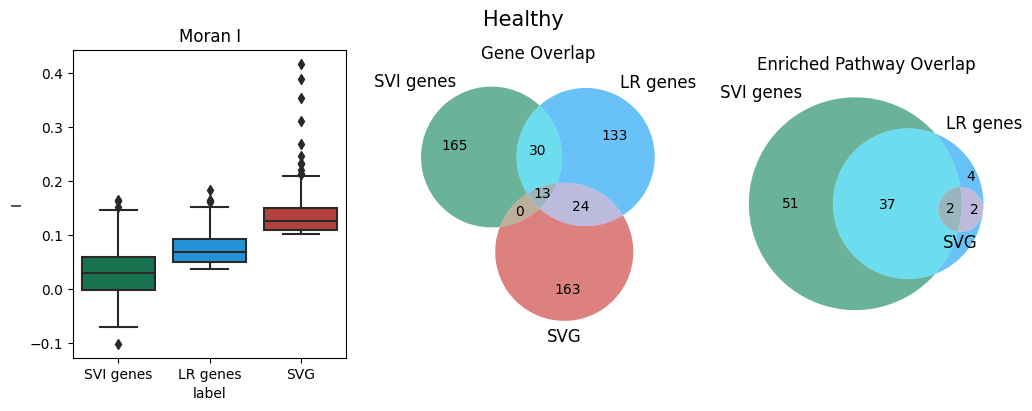

In [11]:
out_f_imp = f'/home/xuezhengyang/data6/02-deconv_1/Script/FigureData/Dataset1/stage2_st_12/SVG/spatalk/'
adata = anndata.read_h5ad(f'{out_f_imp}meta_adata.h5ad')
# /home/xuezhengyang/data6/02-deconv_1/Script/FigureData/Dataset1/stage2_st_12/SVG/spatalk/meta_adata.h5ad
# /home/xuezhengyang/data6/02-deconv_1/Script/FigureData/Dataset1/stage2_st_12/SVI/spatalk/meta_idata.h5ad
out_f_imp = f'/home/xuezhengyang/data6/02-deconv_1/Script/FigureData/Dataset1/stage2_st_12/SVI/spatalk/'
idata = anndata.read_h5ad(f'{out_f_imp}meta_idata.h5ad')
merged_df,lri_pw_list,gene_lr_list,gene_pw_list=draw_diff(adata, idata, 'Healthy',is_human=True)
# plt.savefig('./figures/PDAC_intersect.png', dpi=600,bbox_inches='tight')

In [36]:
df_merged_sub=merged_df.copy()

In [ ]:
# LR genes	SVG	SVI genes

In [37]:
membership=pd.get_dummies(df_merged_sub.set_index('Term')['group']).groupby('Term').sum().astype(str).agg('-'.join, axis=1).reset_index()
membership

,Term,0
0,AGE-RAGE signaling pathway in diabetic complic...,1-1-1
1,Acute myeloid leukemia,0-0-1
2,Adherens junction,1-0-1
3,Adipocytokine signaling pathway,1-0-0
4,Adrenergic signaling in cardiomyocytes,0-0-1
...,...,...
116,Viral protein interaction with cytokine and cy...,1-0-1
117,Wnt signaling pathway,0-0-1
118,Yersinia infection,0-0-1
119,cAMP signaling pathway,0-0-1


In [128]:
for x in membership[0].unique():
    sub_df = df_merged_sub[df_merged_sub.Term.isin(membership[membership[0]==x].Term)]
    if len(sub_df)>20:
        ax = gseapy.dotplot(sub_df, title='',cmap='viridis_r', size=10, figsize=(3,5),top_term=20,show_ring=True, ofname=f'./figures/PDAC_pw_{x}.png')
    else:
        ax = gseapy.dotplot(sub_df, title='',cmap='viridis_r', size=10, figsize=(3,5),top_term=20,show_ring=True, ofname=f'./figures/PDAC_pw_{x}_large.png')
        ax = gseapy.dotplot(sub_df, title='',cmap='viridis_r', size=10, figsize=(3,2),top_term=20,show_ring=True, ofname=f'./figures/PDAC_pw_{x}_small.png')
        
    

In [46]:
sub_df = df_merged_sub[df_merged_sub.Term.isin(membership[membership[0]=='0-0-1'].Term)]
sub_df = sub_df[~sub_df.Term.isin(['Acute myeloid leukemia','Aldosterone synthesis and secretion','Alzheimer disease','Amphetamine addiction','Bacterial invasion of epithelial cells','Circadian entrainment',
                                  'Epithelial cell signaling in Helicobacter pylori infection','Glioma',
                                   'Inflammatory bowel disease',
                                    'Intestinal immune network for IgA production',
                                    'Legionellosis',
                                    'Leishmaniasis',
                                    'Long-term potentiation','Viral myocarditis',
                                    'Human cytomegalovirus infection','Shigellosis','Pathways of neurodegeneration','melanogenesis','Yersinia infection','Viral carcinogenesis',
                                  ])]
gseapy.dotplot(sub_df, title='',cmap='viridis_r', size=10, figsize=(3,5),top_term=20,show_ring=True, ofname=f'./figures/PDAC_pw_0-0-1_SEL.png')

In [61]:
set(lri_pw_list).difference(set(gene_lr_list)).difference(set(gene_pw_list))



# {'Acute myeloid leukemia',
#  'Adrenergic signaling in cardiomyocytes', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3691862/The same signaling pathway also stimulates a complex network of intracellular signaling cascades which regulate the proliferation, migration, angiogenesis and apoptosis of PAC and PDAC cells
#  'Aldosterone synthesis and secretion',
#  'Alzheimer disease',
#  'Amphetamine addiction',
#  'Apelin signaling pathway', https://pubmed.ncbi.nlm.nih.gov/36142542/ Apelin signaling function in tumor cells was characterized in pancreatic tumor cell lines by Western blot as well as proliferation, migration assays and in murine orthotopic xenograft experiments.
#  'Bacterial invasion of epithelial cells',
#  'C-type lectin receptor signaling pathway', https://www.nature.com/articles/s41467-022-28407-4 
#  'Cellular senescence', https://link.springer.com/article/10.1007/s13402-021-00614-z
#  'Central carbon metabolism in cancer', https://www.nature.com/articles/s12276-020-0375-3
#  'Chemokine signaling pathway', https://www.sciencedirect.com/science/article/pii/S1044579X22001961  Chemokines are small soluble factors that are significantly deregulated during PDAC pathogenesis, contributing to tumor growth, metastasis, immune cell trafficking, and therapy resistance.
#  'Circadian entrainment',
#  'Endocytosis', drug intake
#  'Epithelial cell signaling in Helicobacter pylori infection',
#  'Estrogen signaling pathway', https://link.springer.com/article/10.1186/s12885-018-4973-6 correlates with adverse prognosis
#  'Glioma',
#  'HIF-1 signaling pathway',  https://aacrjournals.org/cancerres/article/74/9/2455/599816/Hypoxia-Inducible-Factor-1-Promotes-Pancreatic 1 Promotes Pancreatic Ductal Adenocarcinoma Invasion and Metastasis by Activating Transcription of the Actin-Bundling Protein Fascin
#  'Hematopoietic cell lineage', https://www.sciencedirect.com/science/article/pii/S1074761317303217 Tissue-Resident Macrophages in Pancreatic Ductal Adenocarcinoma Originate from Embryonic Hematopoiesis and Promote Tumor Progression
#  'Human cytomegalovirus infection',
#  'IL-17 signaling pathway', https://www.sciencedirect.com/science/article/pii/S0304383521001075, activates and synergizes with the notch signaling pathway
#  'Inflammatory bowel disease',
#  'Intestinal immune network for IgA production',
#  'Legionellosis',
#  'Leishmaniasis',
#  'Long-term potentiation',
#  'Measles', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9886093/
#  'Melanogenesis',
#  'MicroRNAs in cancer', good
#  'NOD-like receptor signaling pathway',
#  'Neutrophil extracellular trap formation',
#  'Osteoclast differentiation',
#  'Pancreatic cancer',
#  'Parathyroid hormone synthesis, secretion and action',
#  'Pathways of neurodegeneration',
#  'Phototransduction',
#  'Regulation of lipolysis in adipocytes',
#  'Renin secretion',
#  'Salivary secretion',
#  'Shigellosis',
#  'Signaling pathways regulating pluripotency of stem cells',
#  'Th17 cell differentiation',
#  'Toll-like receptor signaling pathway',
#  'Vascular smooth muscle contraction',
#  'Viral carcinogenesis',
#  'Viral myocarditis',
#  'Wnt signaling pathway',
#  'Yersinia infection',
#  'cAMP signaling pathway',
#  'cGMP-PKG signaling pathway'}


{'Acute myeloid leukemia',
 'Adrenergic signaling in cardiomyocytes',
 'Aldosterone synthesis and secretion',
 'Alzheimer disease',
 'Amphetamine addiction',
 'Apelin signaling pathway',
 'Bacterial invasion of epithelial cells',
 'C-type lectin receptor signaling pathway',
 'Cellular senescence',
 'Central carbon metabolism in cancer',
 'Chemokine signaling pathway',
 'Circadian entrainment',
 'Endocytosis',
 'Epithelial cell signaling in Helicobacter pylori infection',
 'Estrogen signaling pathway',
 'Glioma',
 'HIF-1 signaling pathway',
 'Hematopoietic cell lineage',
 'Human cytomegalovirus infection',
 'IL-17 signaling pathway',
 'Inflammatory bowel disease',
 'Intestinal immune network for IgA production',
 'Legionellosis',
 'Leishmaniasis',
 'Long-term potentiation',
 'Measles',
 'Melanogenesis',
 'MicroRNAs in cancer',
 'NOD-like receptor signaling pathway',
 'Neutrophil extracellular trap formation',
 'Osteoclast differentiation',
 'Pancreatic cancer',
 'Parathyroid hormone syn

In [50]:
df_merged_sub_activated_terms = ['Base excision repair','Ferroptosis','VEGF signaling pathway']

In [51]:
df_merged_sub_interaction_terms = ['C-type lectin receptor signaling pathway','Choline metabolism in cancer','ErbB signaling pathway',
                                   'Glutamatergic synapse','Measles','PD-L1 expression and PD-1 checkpoint pathway in cancer',
                                   'Phosphatidylinositol signaling system','Serotonergic synapse','Sphingolipid signaling pathway','Th1 and Th2 cell differentiation']

In [49]:
set(lri_pw_list).difference(set(gene_pw_list)).difference(set(lri_pw_list).difference(set(gene_lr_list)).difference(set(gene_pw_list)))
# {'Adipocytokine signaling pathway',
#  'Basal cell carcinoma',
#  'Breast cancer',
#  'C-type lectin receptor signaling pathway',  https://www.nature.com/articles/s41467-022-28407-4
#  'Choline metabolism in cancer', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4297549/ good
#  'Circadian entrainment',
#  'Colorectal cancer',
#  'Cytosolic DNA-sensing pathway',
#  'ErbB signaling pathway', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7090067/, good
#  'FoxO signaling pathway',
#  'GABAergic synapse',
#  'Gap junction',
#  'Glioma',
#  'Glutamatergic synapse', https://www.sciencedirect.com/science/article/pii/S1043661822005011, good
#  'Inflammatory bowel disease',
#  'Long-term potentiation',
#  'Maturity onset diabetes of the young',
#  'Measles', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9886093/
#  'Melanoma',
#  'Morphine addiction',
#  'Non-alcoholic fatty liver disease',
#  'Non-small cell lung cancer',
#  'Olfactory transduction',
#  'Oocyte meiosis',
#  'Ovarian steroidogenesis',
#  'PD-L1 expression and PD-1 checkpoint pathway in cancer', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7136921/,very good
#  'Pancreatic cancer', good
#  'Phosphatidylinositol signaling system', https://www.nature.com/articles/s41419-019-1320-z, very good
#  'Phospholipase D signaling pathway',
#  'Phototransduction',
#  'RIG-I-like receptor signaling pathway',
#  'Regulation of lipolysis in adipocytes',
#  'Renal cell carcinoma',
#  'Serotonergic synapse', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8039959/, immune
#  'Sphingolipid signaling pathway', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6355186/
#  'T cell receptor signaling pathway', good
#  'Taste transduction',
#  'Th1 and Th2 cell differentiation', good
#  'Thyroid cancer'}

{'Adipocytokine signaling pathway',
 'Basal cell carcinoma',
 'Breast cancer',
 'C-type lectin receptor signaling pathway',
 'Choline metabolism in cancer',
 'Circadian entrainment',
 'Colorectal cancer',
 'Cytosolic DNA-sensing pathway',
 'ErbB signaling pathway',
 'FoxO signaling pathway',
 'GABAergic synapse',
 'Gap junction',
 'Glioma',
 'Glutamatergic synapse',
 'Inflammatory bowel disease',
 'Long-term potentiation',
 'Maturity onset diabetes of the young',
 'Measles',
 'Melanoma',
 'Morphine addiction',
 'Non-alcoholic fatty liver disease',
 'Non-small cell lung cancer',
 'Olfactory transduction',
 'Oocyte meiosis',
 'Ovarian steroidogenesis',
 'PD-L1 expression and PD-1 checkpoint pathway in cancer',
 'Pancreatic cancer',
 'Phosphatidylinositol signaling system',
 'Phospholipase D signaling pathway',
 'Phototransduction',
 'RIG-I-like receptor signaling pathway',
 'Regulation of lipolysis in adipocytes',
 'Renal cell carcinoma',
 'Serotonergic synapse',
 'Sphingolipid signaling

In [13]:
adata.uns['moranI']

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Tac2_Tacr1,0.911026,0.0,0.000005,0.0,0.000999,0.000013,0.0,0.0,0.000999
Pla2g5_Pla2r1,0.899695,0.0,0.000005,0.0,0.000999,0.000012,0.0,0.0,0.000999
Nppa_Npr1,0.891705,0.0,0.000005,0.0,0.000999,0.000013,0.0,0.0,0.000999
Tac1_Tacr1,0.891551,0.0,0.000005,0.0,0.000999,0.000013,0.0,0.0,0.000999
Slit1_Robo2,0.879140,0.0,0.000005,0.0,0.000999,0.000012,0.0,0.0,0.000999
...,...,...,...,...,...,...,...,...,...
Fgf13_Scn5a,0.473627,0.0,0.000005,0.0,0.000999,0.000007,0.0,0.0,0.000999
Plau_Itgb2,0.451529,0.0,0.000005,0.0,0.000999,0.000008,0.0,0.0,0.000999
Ltb_Cd40,0.412804,0.0,0.000005,0.0,0.000999,0.000006,0.0,0.0,0.000999
Il1b_Il1r2,0.401095,0.0,0.000005,0.0,0.000999,0.000006,0.0,0.0,0.000999


In [17]:
unique_lr_human

array(['Abca1', 'Ackr1', 'Ackr2', ..., 'Zp3', 'Zp3r', 'a'], dtype=object)

In [18]:
adata.uns['moranI'].index

Index(['Tac2_Tacr1', 'Pla2g5_Pla2r1', 'Nppa_Npr1', 'Tac1_Tacr1', 'Slit1_Robo2',
       'Npnt_Itga8', 'Slit2_Robo3', 'Sema3b_Nrp2', 'Nptx1_Nptxr',
       'Slit3_Robo2',
       ...
       'Kitl_Kit', 'Sema3g_Plxna4', 'Cdh1_Klrg1', 'Eda_Eda2r', 'Vcl_Alk',
       'Fgf13_Scn5a', 'Plau_Itgb2', 'Ltb_Cd40', 'Il1b_Il1r2', 'Gng11_Kcnj6'],
      dtype='object', length=188)

In [16]:
adata.uns['moranI'].loc[np.intersect1d(unique_lr_human,adata.uns['moranI'].index)].sort_values('I',ascending=False)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh


In [15]:
human_lr = spider.pp.load_lr_df(False)
top=200
l = human_lr['ligand'].to_numpy().flatten()
r = human_lr['receptor'].to_numpy().flatten()
unique_lr_human = np.unique(np.concatenate((l, r)))
genelist_lr = adata.uns['moranI'].loc[np.intersect1d(unique_lr_human,adata.uns['moranI'].index)].sort_values('I',ascending=False)[:top].index.to_list()

Using mouse LR pair dataset.


Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
200
0.17115941092560796 0.05691560514411988 0.037749827132234626


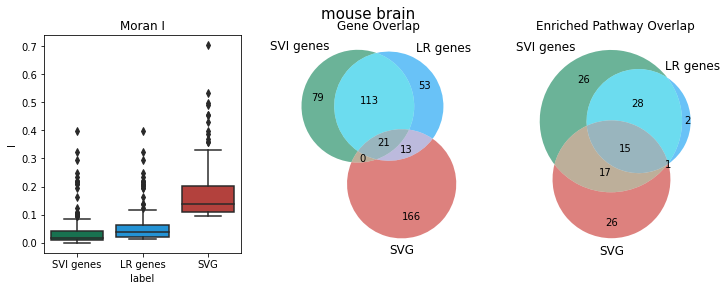

In [34]:

import gseapy
out_f = f'/home/lishiying/data6/01-interaction/results/slideseq_v2/'
adata = anndata.read_h5ad(f'{out_f}adata_SVG.h5ad')
adata.uns['moranI'] = pd.read_csv(f'{out_f}svg_moranI.csv', index_col=0)
out_f = f'/home/lishiying/data6/01-interaction/results/slideseq_v2_meta/'
idata = anndata.read_h5ad(f'{out_f}meta_idata.h5ad')
idata.uns['moranI'] = pd.read_csv(f'{out_f}moranI.csv', index_col=0)
draw_diff(adata, idata, 'mouse brain', is_human=False)
plt.savefig('./figures/slideseq_intersect.png', dpi=600,bbox_inches='tight')

FP200000498TL_D2_stereoseq_deal.h5ad
FP200000498TL_E4_stereoseq_deal.h5ad
FP200000498TL_E5_stereoseq_deal.h5ad
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
200
0.32157636633605785 0.10913950976360798 0.14065031249345228
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
200
0.34767842247589553 0.10963755930501823 0.14077468095092596
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
200
0.3780140214660184 0.11985737575008373 0.1538505923627394


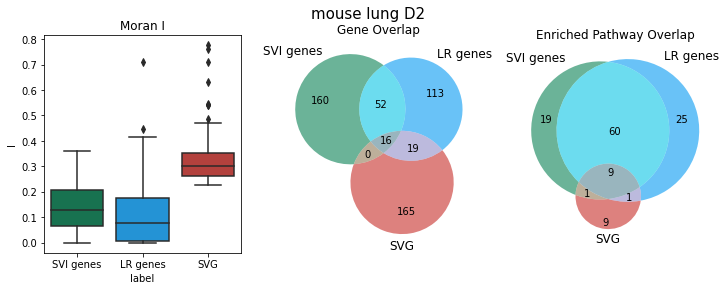

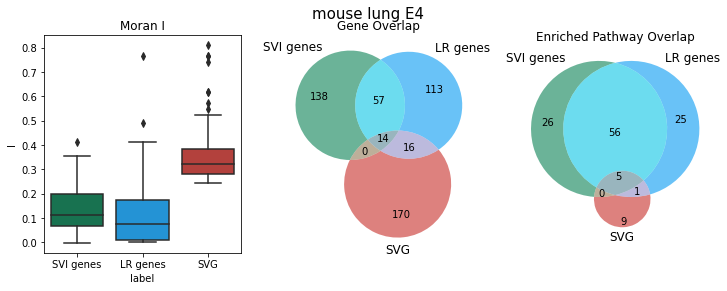

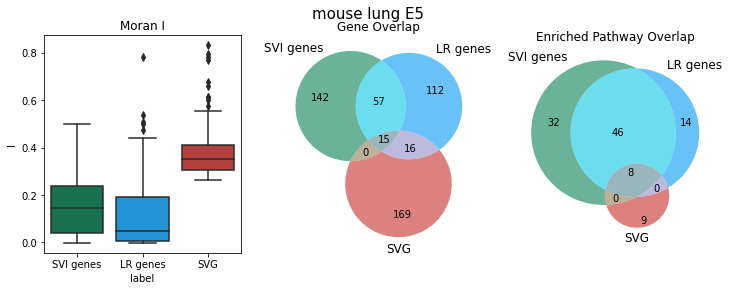

In [33]:

dataset_dir = f'/home/lishiying/data3/mouse/STDS0000062/'
arr = []
for fn in os.listdir(dataset_dir):
    if fn.__contains__('deal'):
        print(fn)
        arr.append([fn.split('_')[1], fn])

for input1 in range(3):
    f = arr[input1][1]
    fn = arr[input1][0]
    out_f = f'/home/lishiying/data6/01-interaction/results/mouse_lung/{fn}_nospatalk/'
    adata = anndata.read_h5ad(f'{out_f}adata_SVG.h5ad')
    adata.uns['moranI'] = pd.read_csv(f'{out_f}svg_moranI.csv', index_col=0)
    idata = anndata.read_h5ad(f'/home/lishiying/data6/01-interaction/results/mouse_lung/{fn}_meta/meta_idata.h5ad')
    idata.uns['moranI'] = pd.read_csv(f'/home/lishiying/data6/01-interaction/results/mouse_lung/{fn}_meta/moranI.csv', index_col=0)
    draw_diff(adata, idata, f'mouse lung {fn}', is_human=False)
    plt.savefig(f'./figures/mouse_lung_{fn}_intersect.png', dpi=600,bbox_inches='tight')


Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.35457267418851224 0.1642074000050166 0.12334600407422615
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.35968333211653075 0.16804897919162903 0.13351696850680833
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.31903274862453973 0.13009452047974096 0.09529874047503703
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.3478919270860071 0.13478779591784917 0.09751674076987982
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.4049777420516535 0.17750702246378683 0.1484914541730435
Mouse KEGG_2019_Mouse
Using mouse LR pair dataset.
50
0.39362924701247226 0.16571128307888 0.13579664057224494


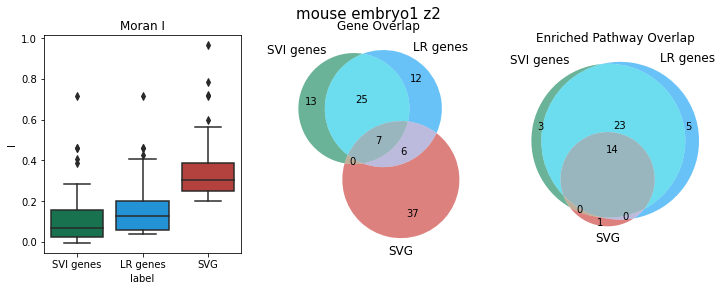

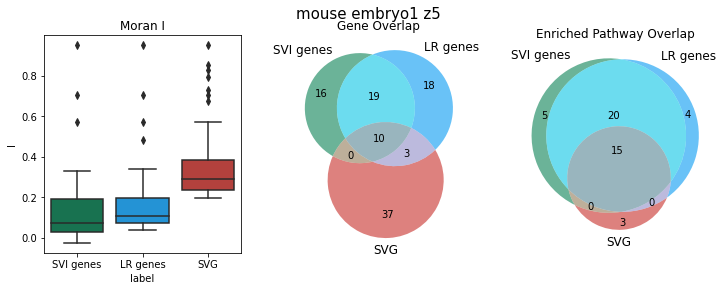

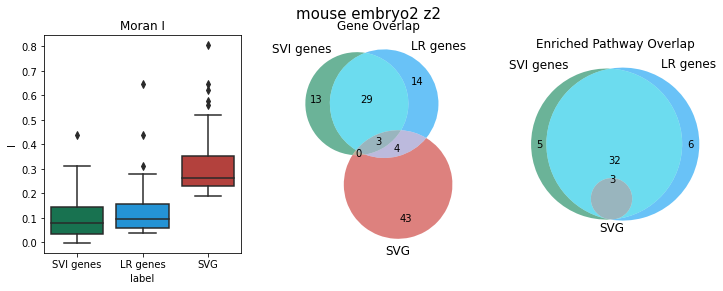

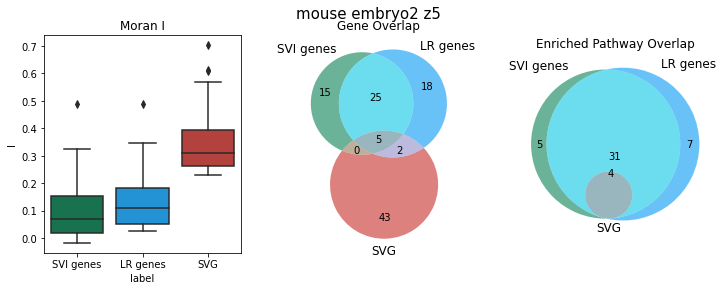

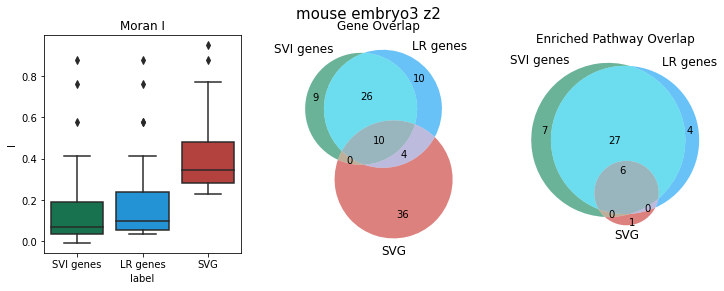

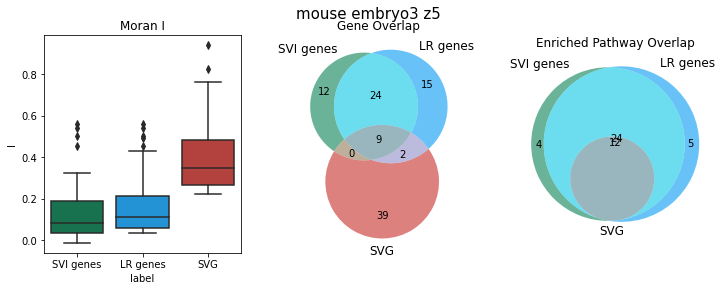

In [32]:
arr = []
for i in [1, 2, 3]:
    for j in [2, 5]:
        out_f = f'/home/lishiying/data6/01-interaction/results/mouse_embryo/embryo{i}_z{j}/'
        adata = anndata.read_h5ad(f'{out_f}adata_SVG.h5ad')
        adata.uns['moranI'] = pd.read_csv(f'{out_f}svg_moranI.csv', index_col=0)
        out_f = f'/home/lishiying/data6/01-interaction/results/mouse_embryo/embryo{i}_z{j}_meta/'
        idata = anndata.read_h5ad(f'{out_f}meta_idata.h5ad')
        draw_diff(adata, idata, f'mouse embryo{i} z{j}', is_human=False, top=50)
        plt.savefig(f'./figures/mouse_embryo{i}_z{j}_intersect.png', dpi=600,bbox_inches='tight')

In [ ]:
{'Adipocytokine signaling pathway',
 'Basal cell carcinoma',
 'Base excision repair', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8546202/
 'Breast cancer',
 'C-type lectin receptor signaling pathway', https://www.nature.com/articles/s41467-022-28407-4
 'Choline metabolism in cancer', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4297549/ good
 'Circadian entrainment',
 'Colorectal cancer',
 'Cytosolic DNA-sensing pathway',
 'Endometrial cancer',
 'ErbB signaling pathway', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7090067/, good
 'Ferroptosis', https://www.nature.com/articles/s41467-020-20154-8, good
 'FoxO signaling pathway', 
 'GABAergic synapse',
 'Gap junction',
 'Glioma',
 'Glutamatergic synapse',   https://www.sciencedirect.com/science/article/pii/S1043661822005011, good
 'Inflammatory bowel disease',
 'Long-term depression',
 'Long-term potentiation',
 'Maturity onset diabetes of the young',
 'Measles', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9886093/
 'Melanoma',
 'Morphine addiction',
 'Nicotinate and nicotinamide metabolism',
 'Nicotine addiction', 
 'Non-alcoholic fatty liver disease',
 'Non-small cell lung cancer',
 'Olfactory transduction',
 'Oocyte meiosis',
 'Ovarian steroidogenesis',
 'PD-L1 expression and PD-1 checkpoint pathway in cancer', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7136921/,very good
 'Pancreatic cancer', good
 'Phosphatidylinositol signaling system',  https://www.nature.com/articles/s41419-019-1320-z, very good
 'Phospholipase D signaling pathway',
 'Phototransduction',
 'Porphyrin and chlorophyll metabolism',
 'Pyrimidine metabolism',
 'RIG-I-like receptor signaling pathway',
 'Regulation of lipolysis in adipocytes',
 'Renal cell carcinoma',
 'Retrograde endocannabinoid signaling',
 'Serotonergic synapse', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8039959/, immune
 'Sphingolipid signaling pathway', https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6355186/
 'T cell receptor signaling pathway',good
 'Taste transduction',
 'Th1 and Th2 cell differentiation',good
 'Thyroid cancer',
 'VEGF signaling pathway'} https://www.nature.com/articles/s41467-022-33991-6,very good, connect with PD-L1